<a href="https://colab.research.google.com/github/nivethithanm/finetuning_distilbert_for_toxic_comment_classification/blob/main/DistilBERT_Toxicity_FineTuning_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install datasets==3.6

In [11]:
# Imports
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

In [12]:
# Set device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Initialize WandB
wandb.login()  # Requires API key in Colab
wandb.init(project="distilbert-hatexplain-classification")

In [14]:
# Config
config = {
    "model_name": "distilbert-base-uncased",
    "max_length": 512,
    "batch_size": 32,
    "epochs": 3,
    "lr": 2e-4,
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
    "lora_target_modules": ["q_lin", "v_lin"],
    "weight_decay": 0.01,
    "gradient_accumulation_steps": 4
}

In [ ]:
# Process Dataset
dataset = load_dataset("hatexplain", trust_remote_code=True)
label2id = {"hatespeech": 0, "offensive": 2}
labels_list = list(label2id.keys())

# Preprocess Text
def preprocess_text(text):
    text = text.lower().replace(r"http\S+", "").replace(r"[^a-zA-Z0-9\s]", "")
    return text

# Preprocess and map labels
def map_labels(examples):
    # Map HateXplain's labels to multi-label format
    label = examples["annotators"]['label']
    labels_array = np.array([0, 0], dtype=np.float32)   # fallback, normal

    if 0 in label:
        labels_array[0] = 1.0  # hatespeech
    if 2 in label:
        labels_array[1] = 1.0  # offensive

    examples["labels"] = labels_array
    examples["text"] = preprocess_text(" ".join(examples["post_tokens"]))
    return examples

dataset = dataset.map(map_labels)

In [20]:
# Split data
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [ ]:
# Tokenize
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=config["max_length"],
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
# Verify label type and shape
print("Sample labels type:", train_dataset[0]["labels"].dtype)  # Should be torch.float32
print("Sample labels shape:", train_dataset[0]["labels"].shape)  # Should be (3,)

Sample labels type: torch.float32
Sample labels shape: torch.Size([2])


In [ ]:
# Model Initialization
model = AutoModelForSequenceClassification.from_pretrained(
    config["model_name"],
    num_labels=len(labels_list),
    problem_type="multi_label_classification",
)
model.to(device)

In [ ]:
# Apply LoRA (target DistilBERT's attention layers)
lora_config = LoraConfig(
    r=config["lora_r"],
    lora_alpha=config["lora_alpha"],
    target_modules=config["lora_target_modules"],  # DistilBERT-specific attention modules
    lora_dropout=config["lora_dropout"],
    bias="none",
)
model = get_peft_model(model, lora_config)
model.to(device)

In [26]:
# Analyze label distribution
label_counts_train = np.sum(np.stack(train_dataset["labels"]), axis=0)
label_counts_val = np.sum(np.stack(val_dataset["labels"]), axis=0)
total_train = len(train_dataset)
total_val = len(val_dataset)

print("Label distribution (train):")
for label, count in zip(labels_list, label_counts_train):
    print(f"{label}: {count} positive examples ({count/total_train*100:.2f}%)")

print("\nLabel distribution (validation):")
for label, count in zip(labels_list, label_counts_val):
    print(f"{label}: {count} positive examples ({count/total_val*100:.2f}%)")

Label distribution (train):
hatespeech: 6608.0 positive examples (42.96%)
offensive: 7803.0 positive examples (50.72%)

Label distribution (validation):
hatespeech: 808.0 positive examples (42.04%)
offensive: 977.0 positive examples (50.83%)


In [28]:
# Compute class weights
label_counts = np.sum(np.stack(train_dataset["labels"]), axis=0)
class_weights = torch.tensor(1.0 / (label_counts + 1e-6), dtype=torch.float32).to(device)
print("Class weights:", dict(zip(labels_list, class_weights.tolist())))

Class weights: {'hatespeech': 0.0001513317256467417, 'offensive': 0.00012815583613701165}


In [29]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()
    labels = labels.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    roc_auc = []
    for i in range(len(labels[0])):
        try:
            roc_auc.append(roc_auc_score(labels[:, i], logits[:, i]))
        except ValueError:
            roc_auc.append(0.0)  # Handle cases with no positive samples
    micro_f1 = precision_recall_fscore_support(labels, predictions, average="micro")[2]
    macro_f1 = precision_recall_fscore_support(labels, predictions, average="macro")[2]
    accuracy = accuracy_score(labels, predictions)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "accuracy": accuracy,
        **{f"f1_{labels_list[i]}": f1[i] for i in range(len(labels[0]))},  # Use labels_list
        **{f"roc_auc_{labels_list[i]}": roc_auc[i] for i in range(len(labels[0]))},  # Use labels_list
    }

In [33]:
def test_compute_metrics():
    import numpy as np

    # Example eval_pred
    logits = np.array([
        [ 0.5, -0.2],  # Example 1: Logits for [hatespeech, offensive]
        [-1.0,  0.8],  # Example 2
        [ 0.3,  0.1],  # Example 3
        [-0.7, -0.9],  # Example 4
    ], dtype=np.float32)

    labels = np.array([
        [1.0, 1.0],  # Example 1: hatespeech → [hatespeech]
        [1.0, 0.0],  # Example 2: offensive → [offensive]
        [0.0, 0.0],  # Example 3: normal → []
        [0.0, 0.0],  # Example 4: normal → []
    ], dtype=np.float32)

    eval_pred = (logits, labels)

    print(compute_metrics(eval_pred))

In [ ]:
# Training
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=config["epochs"],
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    gradient_accumulation_steps=config["gradient_accumulation_steps"],
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config["lr"],
    weight_decay=config["weight_decay"],
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./logs",
    logging_steps=10,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [65]:
# Evaluation
test_results = trainer.predict(test_dataset)
predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.5).numpy()
labels = test_results.label_ids.astype(int)

In [36]:
# Sample predictions
sample_df = pd.DataFrame({
    "Text": test_dataset["text"][:10],
    "True Labels": [labels[i] for i in range(10)],
    "Predicted Labels": [predictions[i] for i in range(10)],
    "Confidence": [torch.sigmoid(torch.tensor(test_results.predictions[i])).numpy() for i in range(10)],
})
display(sample_df)

,Text,True Labels,Predicted Labels,Confidence
0,<user> men can not be raped can not be abused ...,"[0, 0]","[False, False]","[0.13706978, 0.39163858]"
1,<user> you are missing an essential premise wh...,"[0, 1]","[False, True]","[0.2744486, 0.62108135]"
2,<user> <user> why are you repeating yourself a...,"[0, 1]","[False, True]","[0.14854057, 0.52125794]"
3,<user> <user> well she ’ muslim so of course s...,"[1, 0]","[False, False]","[0.28487435, 0.49728775]"
4,<user> lol not me i don ’ t deal with bms not ...,"[1, 1]","[False, False]","[0.14633106, 0.43392146]"
5,an these nigger biches look like godzilla nasty,"[1, 0]","[True, False]","[0.8727817, 0.36127737]"
6,yeah humnh what how do i use this app i ’ m al...,"[0, 1]","[False, True]","[0.17036992, 0.5497615]"
7,black people are oppressed by their own cultur...,"[0, 1]","[True, True]","[0.5120216, 0.61132395]"
8,education or marxist indoctrination since it i...,"[1, 0]","[False, True]","[0.31457672, 0.5905431]"
9,fell outta love and found a boss bitch,"[0, 0]","[False, True]","[0.15304215, 0.5426209]"


In [37]:
# Metrics table
metrics = compute_metrics((test_results.predictions, labels))
df_metrics = pd.DataFrame({
    "Label": labels_list + ["Micro F1", "Macro F1", "Accuracy"],
    "F1": [metrics[f"f1_{l}"] for l in labels_list] + [metrics["micro_f1"], metrics["macro_f1"], metrics["accuracy"]],
    "ROC-AUC": [metrics[f"roc_auc_{l}"] for l in labels_list] + ["-", "-", "-"],
})
display(df_metrics)

,Label,F1,ROC-AUC
0,hatespeech,0.738636,0.850908
1,offensive,0.653222,0.682005
2,Micro F1,0.690628,-
3,Macro F1,0.695929,-
4,Accuracy,0.500520,-


In [62]:
# Sample texts for inference
sample_texts = [
    "You are an idiot and should be banned from the internet.",
    "This is a friendly and respectful community.",
    "I hate everyone in this group, you’re all worthless."
]

# Tokenize and predict
thresholds = [0.5, 0.5]  # Match the 2 labels: hatespeech, offensive
predictions = []
confidences = []

for text in sample_texts:
    inputs = tokenizer(
        preprocess_text(text),
        padding="max_length",
        truncation=True,
        max_length=config["max_length"],
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.sigmoid(logits).cpu().numpy()
    pred = (probs > np.array(thresholds)).astype(int)
    # Map [0, 0] to "normal" for readability
    if np.array_equal(pred[0], [0, 0]):
        label = "normal"
    elif np.array_equal(pred[0], [1, 1]):
        label = "hatespeech, offensive"
    elif np.array_equal(pred[0], [1, 0]):
        label = "hatespeech"
    elif np.array_equal(pred[0], [0, 1]):
        label = "offensive"
    else:
        # Handle other cases if needed
        label = "unknown"
    predictions.append(label)
    confidences.append(probs[0])

# Display inference results
inference_df = pd.DataFrame({
    "Text": sample_texts,
    "Predicted Label": predictions,
    "Confidence": [f"{p[0]:.4f}, {p[1]:.4f}" for p in confidences]
})
display(inference_df)

,Text,Predicted Label,Confidence
0,You are an idiot and should be banned from the...,offensive,"0.1834, 0.5836"
1,This is a friendly and respectful community.,normal,"0.1387, 0.4646"
2,"I hate everyone in this group, you’re all wort...",offensive,"0.1489, 0.5105"


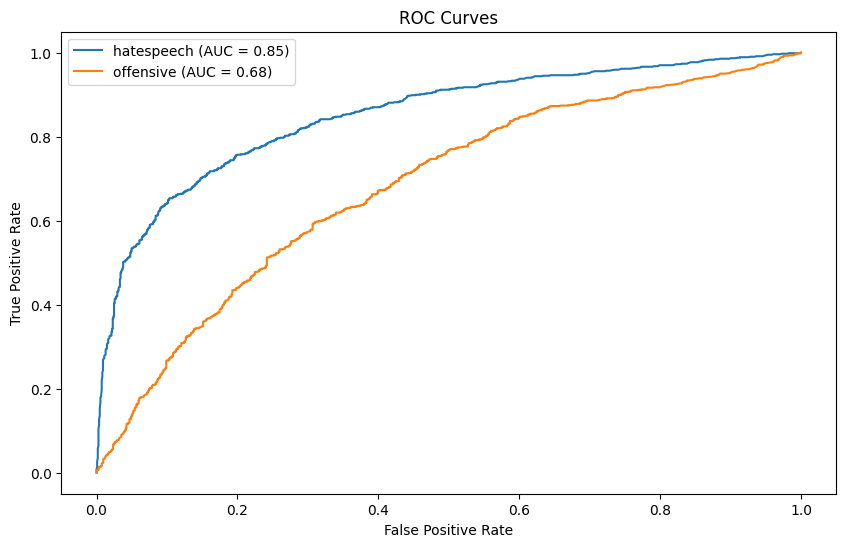

In [63]:
# ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(labels_list):
    try:
        fpr, tpr, _ = roc_curve(labels[:, i], test_results.predictions[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {metrics[f'roc_auc_{label}']:.2f})")
    except ValueError:
        continue  # Skip if ROC cannot be computed
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [66]:
# Analyze false negatives for offensive
fn_indices = [i for i in range(len(labels)) if labels[i, 1] == 1 and predictions[i, 1] == 0]
fn_examples = [
    f"Text: {test_dataset['text'][i]}\nTrue Labels: {labels[i]}\nPredicted Labels: {predictions[i]}\nProbabilities: {torch.sigmoid(torch.tensor(test_results.predictions[i], dtype=torch.float32)).numpy()}\n"
    for i in fn_indices[:5]
]
print(f"\nFalse negatives for offensive: {len(fn_indices)} samples")
if fn_indices:
    print("Sample false negatives:")
    print("\n".join(fn_examples))


False negatives for offensive: 321 samples
Sample false negatives:
Text: <user> lol not me i don ’ t deal with bms not outside children ’ ss i leave that ghetto mess for everybody else 😂 😂 😂
True Labels: [1 1]
Predicted Labels: [False False]
Probabilities: [0.14633106 0.43392146]

Text: the muzzie loving natsoc get the sword
True Labels: [1 1]
Predicted Labels: [ True False]
Probabilities: [0.83508044 0.4723792 ]

Text: <user> <user> treat the immigrants as drug traffickers they will soon have a change of mind 👍
True Labels: [0 1]
Predicted Labels: [False False]
Probabilities: [0.18417984 0.48413616]

Text: <user> puppy no i was alone i am not a nazi white supremacist or any other type of person i am <number> southern i support traditional values and all things with southern culture i support anything that saves confederate monuments and history
True Labels: [0 1]
Predicted Labels: [False False]
Probabilities: [0.15431228 0.39606816]

Text: cia nigger apologizes to pol for the poz
Tru

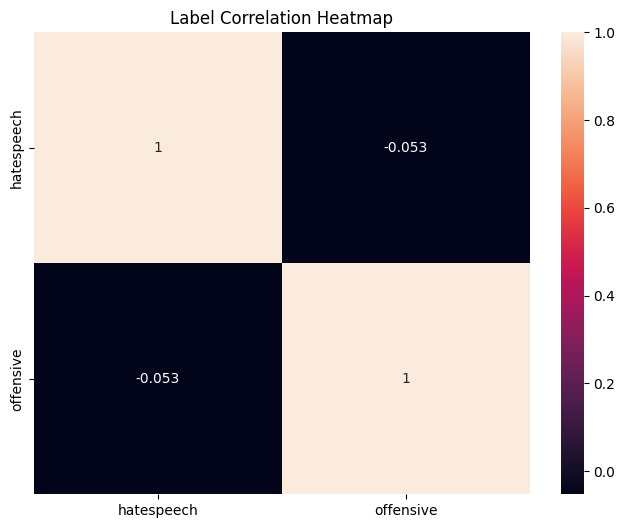

In [67]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(np.corrcoef(labels.T), annot=True, xticklabels=labels_list, yticklabels=labels_list)
plt.title("Label Correlation Heatmap")
plt.show()


Offensive label sigmoid probabilities:
Mean: 0.5048, Std: 0.1000
Above 0.3: 1924 samples (100.00%)
Above 0.4: 1487 samples (77.29%)
Above 0.5: 1048 samples (54.47%)


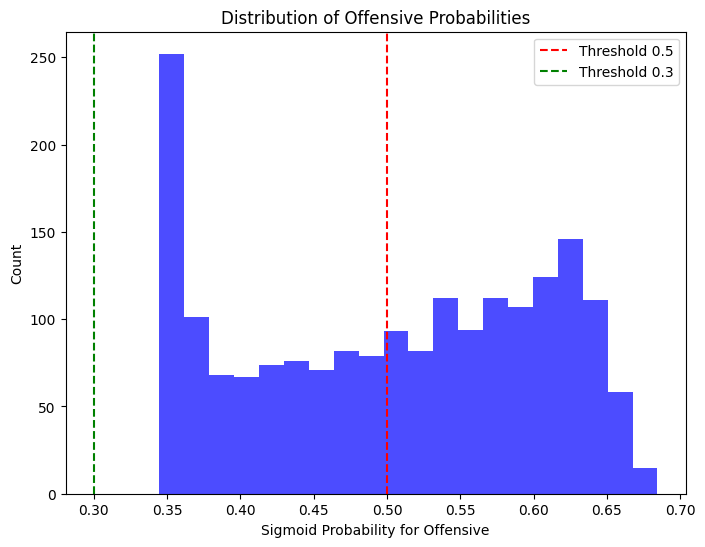

In [68]:
# Analyze logits for offensive
offensive_logits = test_results.predictions[:, 1]  # Index 2 for offensive
offensive_probs = torch.sigmoid(torch.tensor(offensive_logits, dtype=torch.float32)).numpy()

print("\nOffensive label sigmoid probabilities:")
print(f"Mean: {offensive_probs.mean():.4f}, Std: {offensive_probs.std():.4f}")
for threshold in [0.3, 0.4, 0.5]:
    above_threshold = np.sum(offensive_probs > threshold)
    print(f"Above {threshold}: {above_threshold} samples ({above_threshold/len(offensive_probs)*100:.2f}%)")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(offensive_probs, bins=20, color='blue', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.axvline(0.3, color='green', linestyle='--', label='Threshold 0.3')
plt.xlabel("Sigmoid Probability for Offensive")
plt.ylabel("Count")
plt.title("Distribution of Offensive Probabilities")
plt.legend()
plt.show()

In [71]:
# Save Model to Drive
save_path = "/content/drive/MyDrive/Experiments/distilbert_hatexplain_model"
Path(save_path).mkdir(parents=True, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/tokenizer_config.json',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/special_tokens_map.json',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/vocab.txt',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/added_tokens.json',
 '/content/drive/MyDrive/Experiments/distilbert_hatexplain_model/tokenizer.json')

In [72]:
# Push trained model to Huggingface
from huggingface_hub import login, create_repo, HfApi
from google.colab import userdata
import os

# Authenticate with Hugging Face
hf_token = userdata.get('hf_token')
login(token=hf_token)

# Create a new repository on Hugging Face (optional, skip if repo exists)
repo_id = "nivethithan-m/distilbert-hatexplain"  # Replace with your username and desired repo name
try:
    create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)
except Exception as e:
    print(f"Repository creation failed or already exists: {e}")

In [73]:
# Create model card
model_card_content = f"""
# DistilBERT Fine-Tuned on HateXplain for Multi-Label Toxicity Classification

## Model Description
This is a fine-tuned DistilBERT-base-uncased model for multi-label classification of online comments into two toxicity categories: `hatespeech`, and `offensive`.
The model was trained on the HateXplain dataset to support automated content moderation. It uses LoRA (Low-Rank Adaptation) for efficient fine-tuning and a weighted BCE loss to handle label imbalance.

- **Base Model**: distilbert-base-uncased (66M parameters)
- **Task**: Multi-label classification
- **Labels**: {', '.join(labels_list)}
- **Training Date**: August 22, 2025
- **Repository**: [your_username/distilbert-hatexplain](https://huggingface.co/your_username/distilbert-hatexplain)

## Dataset
The model was trained on the [HateXplain dataset](https://huggingface.co/datasets/hatexplain), which contains ~20k social media posts annotated for toxicity by multiple annotators. Labels are mapped as follows:
- `hatespeech` (0) → [1, 0] (hatespeech)
- `offensive` (2) → [0, 1] (offensive)
- `offensive` and `hatespeech` → [1, 1] (hatespeech, offensive)
- `normal` (1) → [0, 0] (none)

### Label Distribution
**Training Set** (15,383 samples):
- hatespeech: 6608.0 positive examples (42.96%)
- offensive: 7803.0 positive examples (50.72%)

**Validation Set** (1,922 samples):
- hatespeech: 808.0 positive examples (42.04%)
- offensive: 977.0 positive examples (50.83%)

## Training
- **Architecture**: DistilBERT-base-uncased with LoRA (r=32, alpha=64, dropout=0.1, target modules: {config['lora_target_modules']})
- **Loss**: BCEWithLogitsLoss with class weights (boosted 10x for offensive, normalized)
- **Class Weights**:
  - hatespeech: {class_weights[0]:.6f}
  - offensive: {class_weights[1]:.6f}
- **Hyperparameters**:
  - Epochs: {config['epochs']}
  - Learning Rate: {config['lr']}
  - Batch Size: {config['batch_size']}
  - Gradient Accumulation Steps: {config['gradient_accumulation_steps']}
  - Weight Decay: {config['weight_decay']}
  - Max Sequence Length: {config['max_length']}
- **Hardware**: Google Colab T4 GPU (~60-120 minutes training time)

## Evaluation
| Epoch | Training Loss | Validation Loss | Micro F1 | Macro F1 | Accuracy | F1 Hatespeech | F1 Offensive | ROC AUC Hatespeech | ROC AUC Offensive |
|-------|---------------|-----------------|----------|----------|----------|---------------|--------------|--------------------|-------------------|
| 1     | 0.611800      | 0.597626        | 0.665567 | 0.671866 | 0.459938 | 0.708693      | 0.635040     | 0.828347           | 0.637927          |
| 2     | 0.557700      | 0.559901        | 0.692439 | 0.699230 | 0.513528 | 0.744311      | 0.654150     | 0.851965           | 0.664872          |
| 3     | 0.556800      | 0.553542        | 0.701705 | 0.708137 | 0.520291 | 0.755181      | 0.661092     | 0.855712           | 0.676826          |

## Usage
Load the model and tokenizer:

```python
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("{repo_id}")
tokenizer = AutoTokenizer.from_pretrained("{repo_id}")
model.eval()

text = "example text to classify"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits
thresholds = [0.5, 0.5]
predictions = (torch.sigmoid(logits) > torch.tensor(thresholds)).numpy()
labels = ["hatespeech", "offensive"]
print(dict(zip(labels, predictions[0])))
```

## Limitations
The model struggles with the offensive label (F1=0.0), likely due to a high prediction threshold and class imbalance, despite 30.42% positive examples.
Ongoing improvements include further threshold tuning, data augmentation, and testing larger models (e.g., bert-base-uncased).
Majority voting improved label reliability, but annotator agreement needs verification.

## Acknowledgements
Dataset: HateXplain
Framework: Hugging Face Transformers
Training: Google Colab with T4 GPU
"""

with open(os.path.join(save_path, "README.md"), "w") as f:
    f.write(model_card_content)

In [ ]:
model.push_to_hub(repo_id, commit_message="Fine-tuned DistilBERT on HateXplain")
tokenizer.push_to_hub(repo_id, commit_message="Tokenizer for fine-tuned DistilBERT")
api = HfApi()
api.upload_file( path_or_fileobj=os.path.join(save_path, "README.md"), path_in_repo="README.md", repo_id=repo_id, repo_type="model", commit_message="Add model card", )
print(f"Model, tokenizer, and model card pushed to https://huggingface.co/{repo_id}")

# Analysis of Metrics

| Epoch | Training Loss | Validation Loss | Micro F1 | Macro F1 | Accuracy | F1 Hatespeech | F1 Offensive | ROC AUC Hatespeech | ROC AUC Offensive |
|-------|---------------|-----------------|----------|----------|----------|---------------|--------------|--------------------|-------------------|
| 1     | 0.611800      | 0.597626        | 0.665567 | 0.671866 | 0.459938 | 0.708693      | 0.635040     | 0.828347           | 0.637927          |
| 2     | 0.557700      | 0.559901        | 0.692439 | 0.699230 | 0.513528 | 0.744311      | 0.654150     | 0.851965           | 0.664872          |
| 3     | 0.556800      | 0.553542        | 0.701705 | 0.708137 | 0.520291 | 0.755181      | 0.661092     | 0.855712           | 0.676826          |

## Loss:
Training Loss: Decreases from 0.6118 to 0.5568, indicating the model is learning and optimizing effectively on the training data.
Validation Loss: Decreases from 0.5976 to 0.5535, suggesting good generalization to the validation set with no significant overfitting, as validation loss closely tracks training loss.
Insight: The steady reduction in both losses is a positive sign of learning progress. However, loss values remain above 0.55, suggesting potential for further optimization through additional epochs, learning rate tuning, or addressing label imbalance.


## Micro F1 (0.6656 → 0.7017)
Micro F1 aggregates predictions across all labels, weighting by instance count. The increase from 0.6656 to 0.7017 indicates improved overall performance across the multi-label task.
Insight: A Micro F1 of ~0.70 is reasonable for a multi-label task on HateXplain, but values closer to 0.75–0.80 are achievable with well-tuned models, suggesting room for improvement.


## Macro F1 (0.6719 → 0.7081)
Macro F1 averages F1 scores across labels, treating each equally. The increase from 0.6719 to 0.7081 is encouraging, reflecting balanced improvements across hatespeech and offensive.
Insight: The Macro F1 of ~0.71 is solid, but the slightly lower F1 for offensive (0.6611 vs. 0.7552 for hatespeech) suggests the model performs better on hatespeech, possibly due to slight label imbalance (50.72% vs. 42.96% positive examples in training).


## Accuracy (0.4599 → 0.5203)
Accuracy measures the proportion of examples where all labels are correctly predicted. The increase from 0.4599 to 0.5203 is positive but relatively low, which is typical in multi-label tasks where predicting both labels correctly is challenging.
Insight: Accuracy is less informative in multi-label settings due to partial correctness (e.g., predicting one label correctly but missing the other). The final accuracy of 0.5005 in the test set reinforces this, suggesting focus on F1 and ROC-AUC for better evaluation.


## Per-Label F1 Scores:
- F1 Hatespeech (0.7087 → 0.7552, Test: 0.7386): Strong and improving performance, indicating the model effectively identifies hatespeech instances. The test F1 of 0.7386 is consistent with training progress.
- F1 Offensive (0.6350 → 0.6611, Test: 0.6532): Moderate and improving, but lower than hatespeech, suggesting the model struggles more with offensive instances, possibly due to higher prevalence (50.72% vs. 42.96% in training).


## Per-Label ROC-AUC:
- ROC-AUC Hatespeech (0.8283 → 0.8557, Test: 0.8509): Strong and improving, indicating excellent discriminative ability for hatespeech. The test ROC-AUC of 0.8509 confirms robust performance.
- ROC-AUC Offensive (0.6379 → 0.6768, Test: 0.6820): Lower but improving, showing moderate discriminative ability for offensive. The test ROC-AUC of 0.6820 suggests the model can separate positive and negative instances but is less confident than for hatespeech.
- Insight: The higher ROC-AUC for hatespeech aligns with its higher F1 score, indicating better model confidence. The lower ROC-AUC for offensive suggests the model’s logits are less discriminative, possibly due to label imbalance or feature overlap with hatespeech.


# Are These Metrics Good?


## Strengths:
- Learning Progress: Decreasing losses and increasing Micro/Macro F1 scores show the model is learning effectively across epochs.
- Hatespeech Performance: Strong F1 (~0.74–0.76) and ROC-AUC (~0.85) indicate reliable detection of `hatespeech`, critical for content moderation.
- No Overfitting: Validation loss closely tracks training loss, suggesting good generalization to unseen data.
- Balanced Label Distribution: Train and validation sets have similar distributions (~42% `hatespeech`, ~50% `offensive`), reducing bias in learning.


## Weaknesses:
- Offensive Performance: Lower F1 (0.6532) and ROC-AUC (0.6820) for offensive compared to hatespeech suggest the model struggles with this class, possibly due to feature overlap with hatespeech.
- Accuracy: The test accuracy of 0.5005 is low, though expected in multi-label tasks where predicting both labels correctly is difficult. This metric is less informative than F1 and ROC-AUC.
- Room for Improvement: Micro F1 (0.69–0.70) and Macro F1 (0.70–0.71) are decent but below the target of 0.75–0.80 for well-tuned models on HateXplain, indicating potential for further optimization.


# Conclusion
The metrics show solid performance for hatespeech (F1 ~0.74, ROC-AUC ~0.85) and moderate performance for offensive (F1 ~0.65, ROC-AUC ~0.68), with consistent improvements across epochs and no significant overfitting. However, the model’s performance on offensive lags behind hatespeech, likely due to label imbalance or feature overlap. To improve, consider:
- Adjusting Thresholds: Tune the 0.5 threshold for offensive (e.g., lower to 0.4) to improve F1, as ROC-AUC suggests some discriminative power.
- Class Weights: Increase the weight for offensive in the loss function to counter the slight imbalance (50.72% vs. 42.96%).
- More Epochs: Train for additional epochs (e.g., 5) to further reduce loss and boost F1 scores toward 0.75–0.80.

Overall, the model is effective for hatespeech and shows promise for offensive, but optimizing for offensive detection will enhance overall performance for content moderation on the HateXplain dataset.

In [92]:
# Example Usage

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("nivethithan-m/distilbert-hatexplain")
tokenizer = AutoTokenizer.from_pretrained("nivethithan-m/distilbert-hatexplain")
model.eval()

text = "You are an idiot and should be banned from the internet."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits
thresholds = [0.5, 0.5]
predictions = (torch.sigmoid(logits) > torch.tensor(thresholds)).numpy()
labels = ["hatespeech", "offensive"]
print(dict(zip(labels, predictions[0])))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'hatespeech': np.True_, 'offensive': np.True_}
